In [5]:
import pandas as pd
import numpy as np

from collections import Counter
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import pymorphy2

from torch.utils.data import Dataset, DataLoader
import pdb
import torch
from torch import cuda
from sklearn.metrics import accuracy_score
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, AutoModelForSeq2SeqLM

from tqdm import tqdm
import os


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'nltk'

In [2]:
torch.cuda.is_available()

True

In [3]:
train_df = pd.read_csv("train.csv", sep="\t")


In [4]:
train_df

,labels,text,clf
0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False
1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False
2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False
3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True
4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False
...,...,...,...
1514,O O O O O O O,Сделка способствует укреплений растущих связей...,True
1515,O B_LOC B_PER I_PER O O O B_PER I_PER O O O O ...,Председатель КНР Ху Цзиньтао и российский през...,False
1516,O O O O O O O O O O O O O B_LOC O B_LOC,Новые поставки нефти почти вдвое увеличат объе...,False
1517,O O O O O O O O O O O B_LOC I_LOC I_LOC,До сих пор доставка сырой нефти осуществлялись...,False


In [5]:
test_df = pd.read_csv("test.csv", sep="\t")

In [6]:
len(train_df)

1519

In [7]:
label_convertor = {
    'O': 1,
    'B_ORG': 2,
    'I_ORG': 3,
    'B_LOC': 4,
    'I_LOC': 5,
    'B_PER': 6,
    'I_PER': 7
}

In [8]:
len(test_df)

2714

In [9]:
lbls = []
for x in train_df.labels:
    lbls.extend(x.split())

## Часть 1

In [9]:
c = Counter(lbls)

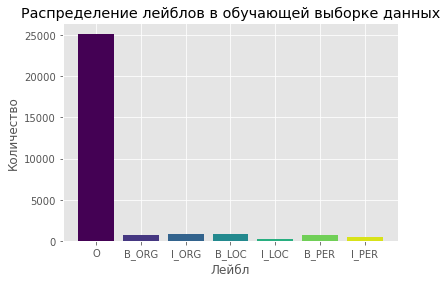

In [10]:
plt.title("Распределение лейблов в обучающей выборке данных")
plt.ylabel('Количество')
plt.xlabel('Лейбл')
my_cmap = plt.get_cmap("viridis")
plt.bar(c.keys(), c.values(), color = my_cmap.colors[::40])
plt.show()

In [11]:
c['ORG'] = c['B_ORG']+c['I_ORG']
c['LOC'] = c['B_LOC']+c['I_LOC']
c['PER'] = c['B_PER']+c['I_PER']

In [12]:
del c['I_ORG']
del c['I_LOC']
del c['I_PER']
del c['B_ORG']
del c['B_LOC']
del c['B_PER']

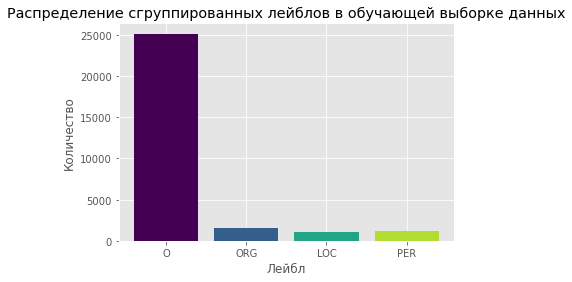

In [13]:
plt.title("Распределение сгруппированных лейблов в обучающей выборке данных")
plt.ylabel('Количество')
plt.xlabel('Лейбл')
my_cmap = plt.get_cmap("viridis")
plt.bar(c.keys(), c.values(), color = my_cmap.colors[::75])
plt.show()

In [14]:
del c['O']

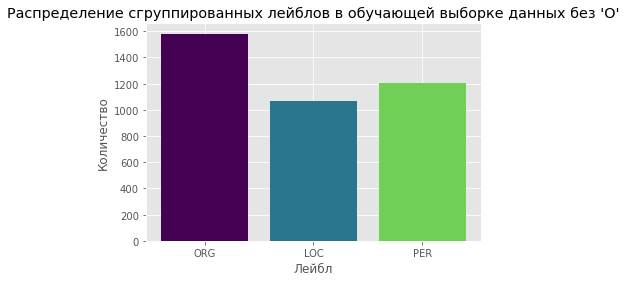

In [15]:
plt.title("Распределение сгруппированных лейблов в обучающей выборке данных без '"'O'"'")
plt.ylabel('Количество')
plt.xlabel('Лейбл')
my_cmap = plt.get_cmap("viridis")
plt.bar(c.keys(), c.values(), color = my_cmap.colors[::100])
plt.show()

### Вывод EDA

Как видно большинство меток представлено лейблом О, что закономерно. Для более объективного отражения распределения тегов, я объеденил их метки BIO, т.к. по сути теги B- и I- являются одной именованной сущностью.
Большинство меток означающих локацию представлены одним тегом.

# Часть 2

### CRF Baseline 

Для реализации бейзлайна необходимо разметить текст POS тегами. Я использовал pymorphy2

In [18]:
def converter(sentence):
    lst = []
    morph = pymorphy2.MorphAnalyzer()
    words = sentence.split()
    for item in words:
        if morph.parse(item)[0].tag.POS is not None:
            lst.append(morph.parse(item)[0].tag.POS)
        else:
            lst.append('UNK')
    return lst

train_df['POS'] = train_df['text'].apply(converter)
test_df['POS'] = test_df['text'].apply(converter)

In [19]:
train_df

,labels,text,clf,POS
0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,"[PREP, NOUN, UNK, NOUN, PREP, NOUN, NOUN, NOUN..."
1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False,"[PREP, NOUN, UNK, PRTF, NOUN, NOUN, UNK, UNK, ..."
2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False,"[NOUN, NOUN, VERB, INFN, PREP, NPRO, NOUN, NOU..."
3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True,"[NOUN, NOUN, VERB, PRTS, PREP, UNK, NOUN, UNK,..."
4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,"[PRTF, NOUN, NOUN, VERB, UNK, CONJ, NOUN, PREP..."
...,...,...,...,...
1514,O O O O O O O,Сделка способствует укреплений растущих связей...,True,"[NOUN, VERB, NOUN, PRTF, NOUN, PREP, NOUN]"
1515,O B_LOC B_PER I_PER O O O B_PER I_PER O O O O ...,Председатель КНР Ху Цзиньтао и российский през...,False,"[NOUN, NOUN, UNK, NOUN, CONJ, ADJF, NOUN, NOUN..."
1516,O O O O O O O O O O O O O B_LOC O B_LOC,Новые поставки нефти почти вдвое увеличат объе...,False,"[ADJF, NOUN, NOUN, ADVB, ADVB, VERB, NOUN, UNK..."
1517,O O O O O O O O O O O B_LOC I_LOC I_LOC,До сих пор доставка сырой нефти осуществлялись...,False,"[PREP, ADJF, NOUN, NOUN, ADJF, NOUN, VERB, PRE..."


В качестве входных признаков в модель подаются кортежи вида (word, POS, tag)

In [20]:
def zipper(data):
    result=[]
    for row in range(data.shape[0]):
        result.append(list(zip(data.text[row].split(' '), data.POS[row], data.labels[row].split(' '))))
    return result

In [21]:
train_df['zipped'] = zipper(train_df)

In [22]:

train_df

,labels,text,clf,POS,zipped
0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False,"[PREP, NOUN, UNK, NOUN, PREP, NOUN, NOUN, NOUN...","[(В, PREP, O), (понедельник, NOUN, O), (28, UN..."
1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False,"[PREP, NOUN, UNK, PRTF, NOUN, NOUN, UNK, UNK, ...","[(Среди, PREP, O), (требований, NOUN, O), (,, ..."
2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False,"[NOUN, NOUN, VERB, INFN, PREP, NPRO, NOUN, NOU...","[(Участникам, NOUN, O), (акции, NOUN, O), (пре..."
3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True,"[NOUN, NOUN, VERB, PRTS, PREP, UNK, NOUN, UNK,...","[(Начало, NOUN, O), (акции, NOUN, O), (было, V..."
4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False,"[PRTF, NOUN, NOUN, VERB, UNK, CONJ, NOUN, PREP...","[(Освещающие, PRTF, O), (акцию, NOUN, O), (бло..."
...,...,...,...,...,...
1514,O O O O O O O,Сделка способствует укреплений растущих связей...,True,"[NOUN, VERB, NOUN, PRTF, NOUN, PREP, NOUN]","[(Сделка, NOUN, O), (способствует, VERB, O), (..."
1515,O B_LOC B_PER I_PER O O O B_PER I_PER O O O O ...,Председатель КНР Ху Цзиньтао и российский през...,False,"[NOUN, NOUN, UNK, NOUN, CONJ, ADJF, NOUN, NOUN...","[(Председатель, NOUN, O), (КНР, NOUN, B_LOC), ..."
1516,O O O O O O O O O O O O O B_LOC O B_LOC,Новые поставки нефти почти вдвое увеличат объе...,False,"[ADJF, NOUN, NOUN, ADVB, ADVB, VERB, NOUN, UNK...","[(Новые, ADJF, O), (поставки, NOUN, O), (нефти..."
1517,O O O O O O O O O O O B_LOC I_LOC I_LOC,До сих пор доставка сырой нефти осуществлялись...,False,"[PREP, ADJF, NOUN, NOUN, ADJF, NOUN, VERB, PRE...","[(До, PREP, O), (сих, ADJF, O), (пор, NOUN, O)..."


In [23]:
#Трансформация в crf признаки

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

### Описание карты признаков:

- слово строчными буквами
- суффиксы
- написано ли слово большими буквами
- написано ли слово с заглавной буквы
- POS
- стоит ли слово в начале предложения
- стоит ли слово в конце предложения
- аналогичные признаки к слово следующему после 

In [24]:
sent2features(train_df.zipped[0][5:7])

[{'bias': 1.0,
  'word.lower()': 'здания',
  'word[-3:]': 'ния',
  'word[-2:]': 'ия',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'NOUN',
  'postag[:2]': 'NO',
  'BOS': True,
  '+1:word.lower()': 'мэрии',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'NOUN',
  '+1:postag[:2]': 'NO'},
 {'bias': 1.0,
  'word.lower()': 'мэрии',
  'word[-3:]': 'рии',
  'word[-2:]': 'ии',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'NOUN',
  'postag[:2]': 'NO',
  '-1:word.lower()': 'здания',
  '-1:word.istitle()': False,
  '-1:word.isupper()': False,
  '-1:postag': 'NOUN',
  '-1:postag[:2]': 'NO',
  'EOS': True}]

In [25]:
X = np.array([sent2features(s) for s in train_df.zipped])
y = np.array([sent2labels(s) for s in train_df.zipped])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((1139,), (380,))

In [94]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
                           c1=0.1,
                           c2=0.1,
                           max_iterations=100,
                           all_possible_transitions=True,
                           verbose=True)

In [27]:
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 1139/1139 [00:00<00:00, 5044.84it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 29816
Seconds required: 0.065

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.05  loss=18549.01 active=29748 feature_norm=1.00
Iter 2   time=0.03  loss=14220.07 active=28694 feature_norm=2.17
Iter 3   time=0.03  loss=12922.98 active=29631 feature_norm=1.98
Iter 4   time=0.03  loss=11783.22 active=28968 feature_norm=1.83
Iter 5   time=0.03  loss=10699.20 active=29465 feature_norm=2.06
Iter 6   time=0.03  loss=9796.49  active=29505 feature_norm=2.47
Iter 7   time=0.03  loss=8149.47  active=29321 feature_norm=3.78
Iter 8   time=0.03  loss=7051.83  active=27537 feature_norm=4.53
Iter 9   time=0.03  loss=6165.95  active=25020 feature_norm=5.98
Iter 10  time=

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

Сравним предикт и тестовые метки

In [28]:
y_pred = crf.predict(X_test)
print(y_pred[0])

['B_PER', 'I_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [29]:
print(y_test[0])

['B_PER', 'I_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [30]:
from sklearn_crfsuite import metrics as crf_metrics

labels = list(crf.classes_)
labels.remove('O')

In [31]:
print(crf_metrics.flat_classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

       B_LOC       0.81      0.81      0.81       210
       B_PER       0.83      0.85      0.84       181
       I_PER       0.87      0.96      0.91       135
       B_ORG       0.70      0.52      0.60       185
       I_ORG       0.66      0.56      0.61       201
       I_LOC       0.70      0.40      0.51        40

   micro avg       0.77      0.71      0.74       952
   macro avg       0.76      0.68      0.71       952
weighted avg       0.76      0.71      0.73       952



### F1 macro

In [32]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7334800447836466

## Подбор гиперпараметров

Аналогично grid search cv подберем лучшие параметры для модели.

In [33]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.4min finished


CPU times: user 5min 29s, sys: 221 ms, total: 5min 30s
Wall time: 5min 30s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0e4706b20>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0e4e819d0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B_LOC', 'B_PER', 'I_PER', 'B_ORG', 'I_ORG', 'I_LOC']),
                   verbose=1)

In [34]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.006923749446980482, 'c2': 0.01673268682842772}
best CV score: 0.7046356384677562
model size: 0.71M


#### Как видно F1 вырос

In [35]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))

0.7418169066161426


# Часть 3

В качестве бейзлайна использована NERDA для быстрого тестирования разных моделей BERT

NERDA - это простая обертка для BERT, работает почти из коробки в формате fit - predict. Для начала нормально.

In [626]:
from NERDA.datasets import get_conll_data, download_conll_data 
from NERDA.models import NERDA

In [ ]:
# создание трейн и тест выборок
X_train, X_test, y_train, y_test = train_test_split(train_df.text, train_df.labels, test_size=0.25, random_state=42)

In [628]:
training={}
training['sentences'] = list(X_train.str.split(' ').values)
training['tags'] = list(y_train.str.split(' ').values)
validation = {}
validation['sentences'] = list(X_test.str.split(' ').values)
validation['tags'] = list(y_test.str.split(' ').values)

In [629]:
# разметка тегов
tag_scheme = [
'B_PER',
'I_PER',
'B_ORG',
'I_ORG',
'B_LOC',
'I_LOC']

In [631]:
# параметры сетки
dropout = 0.1
training_hyperparameters = {
'epochs' : 10,
'warmup_steps' : 500,
'train_batch_size': 13,
'learning_rate': 0.0001
}

In [19]:
# необходимо обязательно указать тег не относящийся к нерам
model = NERDA(
dataset_training = training,
dataset_validation = validation,
tag_scheme = tag_scheme, 
tag_outside = 'O',
transformer = 'DeepPavlov/rubert-base-cased-sentence',
dropout = dropout,
hyperparameters = training_hyperparameters
)

Device automatically set to: cuda


In [20]:
model.train()


 Epoch 1 / 10


100%|██████████| 48/48 [00:01<00:00, 32.65it/s]


Train Loss = 0.971569558774883 Valid Loss = 0.5813402030616999

 Epoch 2 / 10


100%|██████████| 48/48 [00:01<00:00, 32.86it/s]


Train Loss = 0.41601651009510865 Valid Loss = 0.26303737750276923

 Epoch 3 / 10


100%|██████████| 48/48 [00:01<00:00, 35.34it/s]


Train Loss = 0.17906301364895294 Valid Loss = 0.24031017755623907

 Epoch 4 / 10


100%|██████████| 48/48 [00:01<00:00, 35.39it/s]


Train Loss = 0.09475213586649095 Valid Loss = 0.16252596766571514

 Epoch 5 / 10


100%|██████████| 48/48 [00:01<00:00, 35.27it/s]


Train Loss = 0.07140926805070856 Valid Loss = 0.18277965460826331

 Epoch 6 / 10


100%|██████████| 48/48 [00:01<00:00, 35.31it/s]


Train Loss = 0.08243228731126609 Valid Loss = 0.16172007184165219

 Epoch 7 / 10


100%|██████████| 48/48 [00:01<00:00, 35.45it/s]


Train Loss = 0.04476619918238033 Valid Loss = 0.15555491901371474

 Epoch 8 / 10


100%|██████████| 48/48 [00:01<00:00, 32.54it/s]


Train Loss = 0.019721922473929062 Valid Loss = 0.14821996416624947

 Epoch 9 / 10


100%|██████████| 48/48 [00:01<00:00, 35.56it/s]


Train Loss = 0.007755873150679029 Valid Loss = 0.14735968163586222

 Epoch 10 / 10


100%|██████████| 48/48 [00:01<00:00, 35.32it/s]

Train Loss = 0.004423620140269949 Valid Loss = 0.15132482061259603


'Model trained successfully'

In [21]:
model.evaluate_performance(test)

,Level,F1-Score,Precision,Recall
0,B_PER,0.958449,0.961111,0.955801
1,I_PER,0.977941,0.970803,0.985185
2,B_ORG,0.837333,0.826316,0.848649
3,I_ORG,0.837905,0.840000,0.835821
4,B_LOC,0.908665,0.894009,0.923810
5,I_LOC,0.710526,0.750000,0.675000
0,AVG_MICRO,0.891213,NaN,NaN
0,AVG_MICRO,0.871803,NaN,NaN


Всё то же самое, но модель принимает на вход не предложения, а по токенам.

In [22]:
dropout = 0.1
training_hyperparameters = {
'epochs' : 10,
'warmup_steps' : 500,
'train_batch_size': 13,
'learning_rate': 0.0001
}

In [23]:
model = NERDA(
dataset_training = training,
dataset_validation = validation,
tag_scheme = tag_scheme, 
tag_outside = 'O',
transformer = 'DeepPavlov/rubert-base-cased',
dropout = dropout,
hyperparameters = training_hyperparameters
)

Device automatically set to: cuda


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
model.train()


 Epoch 1 / 10


100%|██████████| 48/48 [00:01<00:00, 35.37it/s]


Train Loss = 0.848005279221318 Valid Loss = 0.42972357912609976

 Epoch 2 / 10


100%|██████████| 48/48 [00:01<00:00, 35.48it/s]


Train Loss = 0.2884155170653354 Valid Loss = 0.19936425844207406

 Epoch 3 / 10


100%|██████████| 48/48 [00:01<00:00, 35.53it/s]


Train Loss = 0.1464515306817537 Valid Loss = 0.15661987103521824

 Epoch 4 / 10


100%|██████████| 48/48 [00:01<00:00, 35.18it/s]


Train Loss = 0.09200849710032344 Valid Loss = 0.1576948766790641

 Epoch 5 / 10


100%|██████████| 48/48 [00:01<00:00, 35.05it/s]


Train Loss = 0.06730367323722351 Valid Loss = 0.18877488508587703

 Epoch 6 / 10


100%|██████████| 48/48 [00:01<00:00, 35.15it/s]


Train Loss = 0.05804812159410424 Valid Loss = 0.1692025517404545

 Epoch 7 / 10


100%|██████████| 48/48 [00:01<00:00, 35.73it/s]


Train Loss = 0.027295794771899553 Valid Loss = 0.15733612618714687

 Epoch 8 / 10


100%|██████████| 48/48 [00:01<00:00, 35.02it/s]


Train Loss = 0.014204928984161763 Valid Loss = 0.15552630153979408

 Epoch 9 / 10


100%|██████████| 48/48 [00:01<00:00, 35.31it/s]


Train Loss = 0.0074799549610443964 Valid Loss = 0.15530778949323576

 Epoch 10 / 10


100%|██████████| 48/48 [00:01<00:00, 35.35it/s]

Train Loss = 0.002892506036666666 Valid Loss = 0.1508945101425828


'Model trained successfully'

In [25]:
model.evaluate_performance(test)

,Level,F1-Score,Precision,Recall
0,B_PER,0.950276,0.950276,0.950276
1,I_PER,0.960000,0.942857,0.977778
2,B_ORG,0.832432,0.832432,0.832432
3,I_ORG,0.857895,0.910615,0.810945
4,B_LOC,0.901679,0.908213,0.895238
5,I_LOC,0.702703,0.764706,0.650000
0,AVG_MICRO,0.889244,NaN,NaN
0,AVG_MICRO,0.867497,NaN,NaN


In [26]:
model.evaluate_performance(test)

,Level,F1-Score,Precision,Recall
0,B_PER,0.950276,0.950276,0.950276
1,I_PER,0.960000,0.942857,0.977778
2,B_ORG,0.832432,0.832432,0.832432
3,I_ORG,0.857895,0.910615,0.810945
4,B_LOC,0.901679,0.908213,0.895238
5,I_LOC,0.702703,0.764706,0.650000
0,AVG_MICRO,0.889244,NaN,NaN
0,AVG_MICRO,0.867497,NaN,NaN


Как видно, скор на 14 процентов выше чем у аналогичной модели на crf и это мы запустили модель из коробки

In [15]:
preds = model.predict(list(test_df.text.str.split(" ").values))

In [16]:
len(preds)

2714

In [17]:
flat_list = [item for sublist in preds for item in sublist]

In [18]:
len(flat_list)

56332

In [21]:
converted = []
for i in flat_list:
    if i in label_convertor.keys():
        converted.append(label_convertor[i])

In [22]:
len(converted)

56332

## Аугментация

Для улучшения качества модели решил увеличить количество данных из набора Collection3

In [6]:
from os import listdir
from os.path import isfile, join
mypath = 'new_data/collection3/Collection3/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [7]:
onlyfiles = [name[:-4] for name in onlyfiles]

In [8]:
onlyfiles = sorted(list(set(onlyfiles)))

In [15]:
texts_f

[['Россия рассчитывает на конструктивное воздействие США на Грузию04/08/2008 12:08МОСКВА, 4 авг - РИА Новости.',
  'Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта.',
  'Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.',
  '"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.',
  '"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России.'],
 ['Комиссар СЕ критикует ограничительную политику в отношении беженцев в европейских странах05/08/2008 10:32МОСКВА, 5 августа /Новости-Гру

In [16]:
sortedLinesFinal

[['T1', 'LOC 11 23', 'Новосибирска\n'],
 ['T2', 'LOC 85 97', 'Новосибирска\n'],
 ['T3', 'PER 98 117', 'Владимир Городецкий\n'],
 ['T4', 'PER 225 240', 'Сергея Нелюбова\n'],
 ['T5', 'LOC 297 304', 'Бердска\n'],
 ['T6', 'PER 305 318', 'Владимир Штоп\n']]

In [13]:
import nltk.data
import re

def formatText(str):
        res = []
        for strings in str[2].split():
            if(str[2].split().index(strings) == 0):
                if(len((str[2].split())) >= 1):
                    res.append(strings+" "+"B_"+str[1].split()[0])
                else:
                     res.append(strings+" "+"I_"+str[1].split()[0])
            else:
                res.append(strings+" "+"I_"+str[1].split()[0])
        return res


final = []
texts_f=[]
for file in onlyfiles:
    path_txt = 'new_data/collection3/Collection3/' + file + '.txt'
    path_ann = 'new_data/collection3/Collection3/' + file + '.ann'
    with open(path_txt, 'r') as file:
        text = file.read().replace('\n', '')
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    texts = tokenizer.tokenize(text)
    texts_f.append(texts)
    allLines = []

    
    for line in open(path_ann, "r"):
        allLines.append(re.split(r'\t+', line.rstrip('\t')))
    sortedLines = sorted(allLines,key=lambda x: x[1].split()[1])
    sortedLinesFinal = sorted(allLines,key=lambda x: x[1].split()[2])
    result = []

    sortedLinesFinal = allLines##
    for eachEntity in sortedLinesFinal:
        result.append(formatText(eachEntity))
    result = [item.split() for sublist in result for item in sublist]
    dct_zipped ={}
    dct_zipped['word']=[l2[0] for l2 in result]
    dct_zipped['tag']=[l2[1] for l2 in result]
    for text in texts:
        text = text.replace('\n', ' ')
        text = text.replace('.', '')
        text = text.split()
        fin=[]
        
        for tok in text:
            
            if tok in dct_zipped['word']:
                idx = dct_zipped['word'].index(tok)
                fin.append(dct_zipped['tag'][idx])

            else:
                fin.append('O')
        final.append(fin)


In [14]:
texts_f = [item for sublist in texts_f for item in sublist]

In [15]:
collection = pd.DataFrame({'labels':final, 'text':texts_f})

In [16]:
collection['labels']= [' '.join(map(str, l)) for l in collection['labels']]

In [17]:
tag_scheme = [
'B_PER',
'I_PER',
'B_ORG',
'I_ORG',
'B_LOC',
'I_LOC']

In [18]:
train_df = pd.concat([train_df, collection])

In [19]:
train_df.to_csv("df_clean.csv", sep=",")

## Bert Fine-Tuning

BEST 
config = {#'model_name': "DeepPavlov/rubert-base-cased",
         'max_length':256,
         'train_batch_size':16,
         'valid_batch_size':16,
         'epochs':20,
         'max_grad_norm':10,
         'device': 'cuda' if cuda.is_available() else 'cpu'}

In [20]:
# Основные параметры сетки
config = {'max_length':256,
         'train_batch_size':16,
         'valid_batch_size':16,
         'epochs':20,
         'max_grad_norm':10,
         'device': 'cuda' if cuda.is_available() else 'cpu'}

In [21]:
# Декодинг тегов
output_labels = {'B_LOC': 3,
 'B_ORG': 1,
 'B_PER': 5,
 'I_LOC': 4,
 'I_ORG': 2,
 'I_PER': 6,
 'O': 0}

labels_to_ids = {v:k for k,v in enumerate(output_labels)}
ids_to_labels = {k:v for k,v in enumerate(output_labels)}

In [22]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(" ")


        encoding = self.tokenizer(
                             text=sentence,
                             add_special_tokens=True,
                             pad_to_max_length=True,
                             return_attention_mask = True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=self.max_len)
                           
        
        labels = [labels_to_ids[label] for label in word_labels] 

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] != 0 and mapping[0] != encoding['offset_mapping'][idx-1][1]:
                try:
                    encoded_labels[idx] = labels[i]
                except:
                    pass
                i += 1
            else:
                if idx==1:
                    encoded_labels[idx] = labels[i]
                    i += 1

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

    def __len__(self):
        return self.len

In [23]:
# Загрузка токенайзера и модели из hugging face
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = BertForTokenClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=len(output_labels))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initializ

## Ниже закомментированы строки по импорту аугментации
Мной была использована аугментация двух типов.
1. Из набора данных Collection3 - скор почему-то падал. Возможно это связано с тем, что deeppavlov обучали свой берт используя этот набор.
2. Набор данных подготовленный моим сокомандником. В данном случае из-за недостаточности меток I_LOC были выбраны предложения содержащие данную метку и заменены синонимами. Идея была сохранить контекст, но применительно к другим именованным сущностям.

Оба примера аугментации не дали прироста точности в экспериментах.

### Апсемплинг

Апсемплинг примеров с тегом I_LOC дал прирост 2 тысячных на лидерборде, что позволило оторваться от 2 места.

In [17]:
data_df = pd.read_csv("df_clean.csv")

In [18]:
data_df

,Unnamed: 0,labels,text,clf
0,0,O O O O O O B_ORG I_ORG O B_LOC I_LOC O O O O ...,В понедельник 28 июня у здания мэрии Москвы на...,False
1,1,O O O O O O O O O O O B_LOC B_PER I_PER O O O ...,"Среди требований , выдвигаемых организаторами ...",False
2,2,O O O O O O O O O O O O O O O O O O O O B_PER ...,Участникам акции предлагалось принести с собой...,False
3,3,O O O O O O O O O O O O O O O O O,Начало акции было намечено на 19 часов ; подчё...,True
4,4,O O O O O O O O O O O O O B_LOC I_LOC I_LOC O ...,"Освещающие акцию блоггеры сообщили , что автоб...",False
...,...,...,...,...
10298,8779,O O O O O O O O O O O O O O O O O O O O O O O ...,"Увольнению предшествовал строгий выговор, полу...",NaN
10299,8780,O O O O O O O O O O O O O O O O O O O O O O O ...,"Ссылаясь на ""достоверные источники"", издание у...",NaN
10300,8781,O O O O,Была организована прокурорская проверка.,NaN
10301,8782,O O O O O O O,В итоге начальник транспортной службы был уволен.,NaN


In [25]:
train_df = pd.read_csv("train.csv", sep="\t")
# test_texts = pd.read_csv("test.csv", sep="\t")

In [26]:
# def splitter(data):
#     return data.split(' ')
# train_df['labels'] = train_df['labels'].apply(splitter)
# # test_texts['text'] = test_texts['text'].apply(splitter)

In [27]:
# train_df = train_df[train_df['labels'].str.len()<=38]

In [28]:
# train_df['labels'].str.len().quantile(0.95)

In [29]:
# test_texts['text'].str.len().max()

In [30]:
# to_aug = data_df[train_df.shape[0]:]

In [31]:
# to_aug = to_aug[to_aug["labels"].str.contains('I_LOC')]

In [32]:
# to_aug = to_aug[~to_aug["labels"].str.contains('B_ORG')]
# to_aug = to_aug[~to_aug["labels"].str.contains('B_PER')]

In [33]:
# data_df = pd.read_csv("df_clean.csv")

In [34]:
# data_df = data_df[:int(train_df.shape[0]+train_df.shape[0]*0.5)]
data_df = data_df[:train_df.shape[0]]

In [35]:
# data_df = data_df.merge(train_df, left_index=True, right_index=True)

In [36]:
# data_df = data_df[['labels_x', 'text_x']]

In [37]:
data_df.rename(columns={'text_x': 'sentence', 'labels_x':'word_labels'}, inplace=True)

In [38]:
# data_df = pd.concat([data_df, to_aug]) 

In [39]:
# def splitter(data):
#     return data.split(' ')

In [40]:
# to_aug["labels"]=to_aug.labels.apply(splitter)

In [41]:
# to_aug["text"]=to_aug.text.apply(splitter)

In [42]:
# to_aug['zipper']=to_aug.apply(lambda x: list(zip(x.text,x.labels)), axis=1)


In [43]:
data_df.rename(columns={'text': 'sentence', 'labels':'word_labels'}, inplace=True)

In [44]:
to_aug = data_df.copy()

In [45]:
to_aug = to_aug[to_aug["word_labels"].str.contains('I_LOC')]

In [46]:
to_aug = to_aug[~to_aug["word_labels"].str.contains('B_ORG')]
to_aug = to_aug[~to_aug["word_labels"].str.contains('B_PER')]

In [47]:
to_aug = to_aug.append([to_aug]*5, ignore_index=True)

In [48]:
# aug = pd.read_csv("aug_1_I_LOC_2.csv", delimiter='\t')

In [49]:
# aug.rename(columns={'0': 'sentence', 'tags':'word_labels'}, inplace=True)

In [50]:
# aug = aug[['sentence', 'word_labels']]

In [51]:
data_df = pd.concat([data_df, to_aug])

In [52]:
# Подготовка данных для даталоадера
data = data_df[['sentence', 'word_labels']]
train_size = 1
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, config['max_length'])
#testing_set = dataset(test_dataset, tokenizer, config['max_length'])

FULL Dataset: (1783, 2)
TRAIN Dataset: (1783, 2)
TEST Dataset: (0, 2)


In [53]:
train_params = {'batch_size': config['train_batch_size'],
                'shuffle': True,
                'num_workers': 8,
                'pin_memory':True
                }

test_params = {'batch_size': config['valid_batch_size'],
                'shuffle': True,
                'num_workers': 8,
                'pin_memory':True
                }

training_loader = DataLoader(training_set, **train_params)


In [54]:
# testing_loader = DataLoader(testing_set, **test_params)

In [55]:
device = config['device']

In [56]:
# Инициализация модели
model.to(device)
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels,
               return_dict=False)
initial_loss = outputs[0]
initial_loss

tensor(1.7229, device='cuda:0', grad_fn=<NllLossBackward0>)

Модель тестировалась на разных оптимизаторах

In [57]:
# optimizer = torch.optim.Adam(params=model.parameters(), eps=1e-8, lr=1e-5)

optimizer = AdamW(model.parameters(),
    lr=1e-5,
    eps=1e-8
)

In [58]:
# train цикл
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                               return_dict=False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           

        flattened_targets = labels.view(-1)
        active_logits = tr_logits.view(-1, model.num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1)
        

        active_accuracy = labels.view(-1) != -100
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=config['max_grad_norm']
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    return epoch_loss, tr_accuracy

In [59]:
loss_values = []
accuracies = []

In [60]:
for epoch in range(config['epochs']):
    print(f"Training epoch: {epoch + 1}")
    epoch_loss,tr_accuracy =  train(epoch)
    loss_values.append(epoch_loss)
    accuracies.append(tr_accuracy)

Training epoch: 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingfac

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training loss per 100 training steps: 0.04934221878647804
Training loss per 100 training steps: 0.06368811494016116
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training loss epoch: 0.06192378768797165
Training accuracy epoch: 0.9845249027467992
Training epoch: 4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training loss per 100 training steps: 0.0024891062639653683
Training loss per 100 training steps: 0.009153198549929674
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training loss epoch: 0.008576643850704255
Training accuracy epoch: 0.9981197684889775
Training epoch: 9
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to av

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training loss per 100 traini

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training loss per 100 training steps: 0.00046006322372704744
Training loss per 100 training steps: 0.0015439117117842548
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training loss epoch: 0.001455500843413964
Training accuracy epoch: 0.9996914367567037
Training epoch: 20
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TO

Кривые отрисованы с 5 эпохи, для более точного отображения ошибок в масштабе.
На первом графике кривая лосс, на втором точность

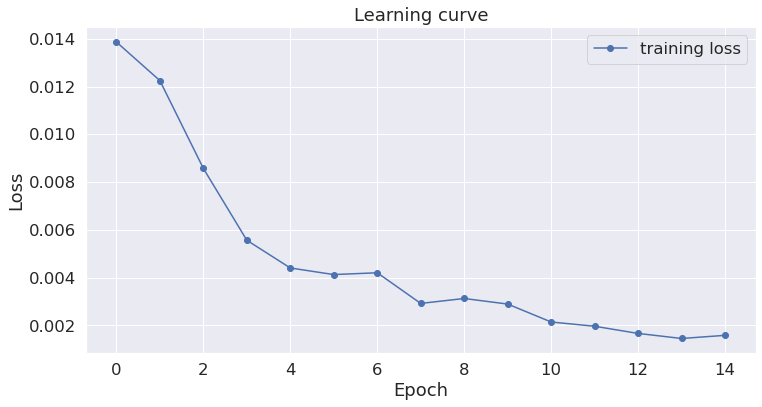

In [61]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values[5:], 'b-o', label="training loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

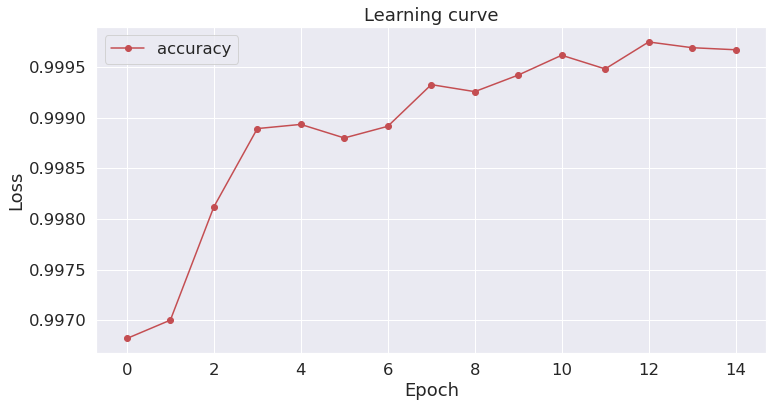

In [62]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(accuracies[5:], 'r-o', label="accuracy")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Валидация

In [63]:
def valid(model, testing_loader):
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels,
                                     return_dict=False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            flattened_targets = labels.view(-1)
            active_logits = eval_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)
            

            active_accuracy = labels.view(-1) != -100
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [64]:
labels, predictions = valid(model, testing_loader)

NameError: name 'testing_loader' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

f1_score(labels, predictions, average='macro')

Ниже записаны различные параметры на которых обучалась модель, к сожалению большую часть экспериментов писал в кагле, так что тут только черновые результаты

In [36]:
#0.8773366875139016 eps 2e-8

#0.867972186720751
#0.8700343353606167 30 ep

#0.8811993116763438 adam, 30ep
#0.8757490808631038 adam, 35ep
# 0.8931064547158766 35ep

In [ ]:
print(classification_report(labels, predictions, target_names=['B_LOC', 'B_ORG', 'B_PER', 'I_LOC', 'I_ORG', 'I_PER', 'O']))

### Валидация на данных для kaggle

In [65]:
model.eval()
def inference(sentence):
    inputs = tokenizer(sentence,
                        return_offsets_mapping=True, 
                        padding='max_length', 
                        truncation=True, 
                        max_length=config['max_length'],
                        return_tensors="pt")

    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    outputs = model(ids, attention_mask=mask, return_dict=False)
    logits = outputs[0]

    active_logits = logits.view(-1, model.num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1)

    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
    wp_preds = list(zip(tokens, token_predictions))

    prediction = []
    out_str = []
    off_list = inputs["offset_mapping"].squeeze().tolist()
    for idx, mapping in enumerate(off_list):



        if mapping[0] != 0 and mapping[0] != off_list[idx-1][1]:
            prediction.append(wp_preds[idx][1])
            out_str.append(wp_preds[idx][0])
        else:
            if idx == 1:
                prediction.append(wp_preds[idx][1])
                out_str.append(wp_preds[idx][0])
            continue
    return prediction, out_str

In [100]:
from os import listdir
from os.path import isfile, join
mypath='/home/jovyan/mnt/MKB/for_ner/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [211]:
my_excel_file = ["/home/jovyan/mnt/MKB/for_ner/60 3 кв 19_ВТК.xls"]
values = []
for file in my_excel_file:
    my_excel_file = file
    df = pd.read_excel(my_excel_file)
    my_list = (list)(df.values)
    my_second_list = (list)(df[df.columns[1]].values)
    for my_item in my_list:
            values.append(my_item)

In [212]:
values = [[x for x in y if str(x) != 'nan'] for y in values]

In [213]:
values =  [str(y)[1:-1] for y in values if len(y)>0]

In [214]:
values  = [''.join(x[1:-1]) for x in values] 

In [86]:
 # xList =['Оборотно-сальдовая ведомость по счету 67',
#        'Период: 3 квартал 2021 г',
#        'Выводимые данные: сумма', '79713607.44', 'Дебет', 'Кредит',
#         'Анатий Александр Федорович', 'ИП Белоусов Сергей Николаевич',
#         'Детализация по субсчетам, субконто: Контрагенты',
#         'Общество с ограниченной ответственностью "Форт',
#         'Оборотно-сальдовая ведомость по счету 60 за 2 квартал 2021 г. ООО  АЙТИ ПАРТНЕР',
#          'Оборотно-сальдовая ведомость по счету 60 за 3 квартал 2021 г. ООО  Баррус. Проектная логистика',
#        ]

In [215]:
test_texts = pd.DataFrame()

In [216]:
test_texts['text'] = values

In [217]:
test_texts['predict'] = test_texts['text'].apply(inference)

In [218]:
df3 = pd.DataFrame(test_texts['predict'].to_list(), columns=['pred_labels','pred_words'])

In [223]:
for e, x in enumerate(df3.pred_labels.values):
        print(test_texts['text'][e])
        print(x)

Оборотно-сальдовая ведомость по счету 60 за 3 квартал 2019 г.
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Выводимые данные:', 'БУ (данные бухгалтерского учета)
['O', 'O', 'O', 'O', 'O', 'O']
Единица измерения:', 'рубль (код по ОКЕИ 383)
['O', 'O', 'O', 'O', 'O', 'O', 'O']
Счет', 'Сальдо на начало периода', 'Обороты за период', 'Сальдо на конец периода
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Контрагенты', 'Дебет', 'Кредит', 'Дебет', 'Кредит', 'Дебет', 'Кредит
['O', 'O', 'O', 'O', 'O', 'O', 'O']
Договоры
['O']
60', 60975370.37, 791064488.53, 6520226863.93, 6269706791.600001, 171968878.98, 651537924.8
['O', 'O', 'O', 'O', 'O', 'O', 'O']
60.01', 791064488.53, 4187965837.32, 4048439273.6, 651537924.8
['O', 'O', 'O', 'O', 'O']
АБМ ТРЕЙД ООО', 10073976.2, 10073976.
['B_ORG', 'I_ORG', 'I_ORG', 'O', 'O']
Договор 30/08-2019 от 30.08.2019', 10073976.2, 10073976.
['O', 'O', 'O', 'O', 'O', 'O']
АЛПАННЕФТЬ-РЕСУРС ООО', 3911659.66, 3911659.6
['B_ORG', 'I_ORG', 'O', 'O']
до

In [219]:
for e, x in enumerate(df3.pred_labels.values):
    for i in x:
        if i=='B_ORG':
            print(test_texts['text'][e])
            print(x)

АБМ ТРЕЙД ООО', 10073976.2, 10073976.
['B_ORG', 'I_ORG', 'I_ORG', 'O', 'O']
АЛПАННЕФТЬ-РЕСУРС ООО', 3911659.66, 3911659.6
['B_ORG', 'I_ORG', 'O', 'O']
БИТУМ ООО', 39723075.9, 39723075.
['B_ORG', 'I_ORG', 'O', 'O']
БОСФОР-БУНКЕР ООО', 375000, 37500
['B_ORG', 'O', 'O', 'O']
БУНКЕР-ТРЕЙД ООО', 560529, 56052
['B_ORG', 'I_ORG', 'O', 'O']
ГАЗПРОМНЕФТЬ-РЕГИОНАЛЬНЫЕ ПРОДАЖИ ООО', 32140641.2, 32140641.
['B_ORG', 'O', 'O', 'O', 'O']
ДАЛЬНЕВОСТОЧНАЯ ТАНКЕРНАЯ КОМПАНИЯ ООО', 7947525.6, 24856443.36, 25025283.36, 8116365.
['O', 'B_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O']
ИАТ ВОЛХОНКА ООО', 42347.76, 42347.7
['B_ORG', 'I_ORG', 'I_ORG', 'O', 'O']
ИВЦ АЛЬТА ООО', 60000, 6000
['B_ORG', 'I_ORG', 'I_ORG', 'O', 'O']
Интертек Тестинг Сервис-Центр ООО', 2400, 114657.6, 114657.6, 240
['B_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O']
КАРТРИДЖ ПРОМ СЕРВИС ООО', 6669.38, 6669.3
['B_ORG', 'O', 'O', 'O', 'O', 'O']
Договор УПСк180/35-15 от 23.03.2015г.', 11491.32, 11491.3
['O', 'B_ORG', 'O', 'O', 'O', 'O']
КО

In [220]:
for e, x in enumerate(df3.pred_labels.values):
    for i in x:
        if i=='B_PER':
            print(test_texts['text'][e])
            print(x)

Бараненко Данила Александрович', 338, 33
['B_PER', 'B_PER', 'I_PER', 'O', 'O']
Бараненко Данила Александрович', 338, 33
['B_PER', 'B_PER', 'I_PER', 'O', 'O']
ГАЗПРОМНЕФТЬ МАРИН БУНКЕР ООО', 143509943.91, 1272628266.64, 1265770759.6899998, 136652436.9
['O', 'B_PER', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O']
Горбова Екатерина Сергеевна', 28080, 2808
['B_PER', 'B_PER', 'I_PER', 'O', 'O']
Горбова Екатерина Сергеевна', 28080, 2808
['B_PER', 'B_PER', 'I_PER', 'O', 'O']
МАРИНА ЛОДЖИСТИКС ООО', 500000, 1165000, 1038000, 37300
['B_PER', 'B_ORG', 'I_ORG', 'O', 'O', 'O', 'O']
интернет Ерёмин', 101, 10
['B_PER', 'I_PER', 'O', 'O']
Рома Виер', 1158.41, 1158.4
['B_PER', 'I_PER', 'O', 'O']
ПЕТРОСТАТ', 345, 34
['B_PER', 'O', 'O']
САВАННА ООО', 5115, 511
['B_PER', 'I_ORG', 'O', 'O']
Соловых Сергей Борисович Индивидуальный предприниматель', 4130, 413
['I_PER', 'B_PER', 'I_PER', 'O', 'O', 'O', 'O']
Султанова Людмила Узбековна ИП', 29120, 2912
['I_PER', 'B_PER', 'I_PER', 'O', 'O', 'O']
Федотова Елена Юрьевна'

In [161]:
label_convertor = {
    'O': 1,
    'B_ORG': 2,
    'I_ORG': 3,
    'B_LOC': 4,
    'I_LOC': 5,
    'B_PER': 6,
    'I_PER': 7
}

Конвертирование в формат для кагла

In [33]:
flat_list = [item for sublist in df3['pred_labels'].values for item in sublist]

converted = []
for i in flat_list:
    if i in label_convertor.keys():
        converted.append(label_convertor[i])

In [34]:
df = pd.DataFrame({"Predicted": converted})
df.to_csv("sample_submission.csv", sep=",", index_label="Id")

# Часть 4 - Выводы

Как и ожидалось, crf модель весьма устаревшая для поиска неров дала наихудший результат. По этой же причине я не пытался использовать Наташу.
Было предсказуемо, что BERT от deeppavlov справится с задачей лучше всего.
Из параметров повлиявших на высокий результат был подбор входного размера - 160, что позволило увеличить размер батча до 32. Оптимизатор AdamW так же дал прирост при файнтюнинге, ну и настройки его гиперпараметров: эпсилон и скорости обучения. 
Количество эпох более 35 приводило к переобучению и снижению качества модели. Эксперименты с дропаутом и max_grad_norm улучшений не дали, как правило все вело к ухудшению качества модели. 

Попытки аугментировать данные не позволили поднять качество модели, что само по себе странно и удивило. Я был уверен, что за счет этого сделаю лучший результат. Возможно это бы помогло при использовании bert-multilingual, а модель от диппавлов и так достаточно хорошо обучена. Зато апсемплинг позволил улучшить результаты, очевидно примеров с тегом I_LOC в выборке очень мало, большая часть ошибок приходится именно на него.